In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-detection-fer/test/fearful/im292.png
/kaggle/input/emotion-detection-fer/test/fearful/im1022.png
/kaggle/input/emotion-detection-fer/test/fearful/im633.png
/kaggle/input/emotion-detection-fer/test/fearful/im934.png
/kaggle/input/emotion-detection-fer/test/fearful/im927.png
/kaggle/input/emotion-detection-fer/test/fearful/im966.png
/kaggle/input/emotion-detection-fer/test/fearful/im662.png
/kaggle/input/emotion-detection-fer/test/fearful/im648.png
/kaggle/input/emotion-detection-fer/test/fearful/im178.png
/kaggle/input/emotion-detection-fer/test/fearful/im817.png
/kaggle/input/emotion-detection-fer/test/fearful/im308.png
/kaggle/input/emotion-detection-fer/test/fearful/im623.png
/kaggle/input/emotion-detection-fer/test/fearful/im651.png
/kaggle/input/emotion-detection-fer/test/fearful/im72.png
/kaggle/input/emotion-detection-fer/test/fearful/im229.png
/kaggle/input/emotion-detection-fer/test/fearful/im444.png
/kaggle/input/emotion-detection-fer/test/fearful/im415.p

In [6]:
#needed Libraries
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam 
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve,precision_score, recall_score, f1_score,  accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import shutil

#inceptionV3 is a pre-trained model (meaning it has already learned general patterns by training on millions of images)

In [7]:
# the  baseline model
weights_path = '/kaggle/input/inceptionv3-weights-h5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

baseline_model = InceptionV3(weights=weights_path, include_top=False, input_shape=(224, 224, 3)) 
x = baseline_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) 
output = Dense(7, activation='softmax')(x) # For 7 emotion categories 
baseline_model = Model(inputs=baseline_model.input, outputs=output) 
# Freeze all layers in the baseline model 
for layer in baseline_model.layers: layer.trainable = False 
# Compile the baseline model
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])  



In [8]:
#data prep 
# Paths to the dataset directories
original_train_dir = '/kaggle/input/emotion-detection-fer/train'
original_test_dir = '/kaggle/input/emotion-detection-fer/test'

# Paths for new directories after the split (Writable directories)
new_train_dir = '/kaggle/working/new_train'
new_val_dir = '/kaggle/working/new_val'
test_dir = original_test_dir  # Keep the original test set as is

# Create directories if they do not exist
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)

# Split the original training set into a new training set (80%) and validation set (20%)
for emotion in os.listdir(original_train_dir):
    emotion_path = os.path.join(original_train_dir, emotion)
    
    # Create emotion folders in the new training and validation directories
    os.makedirs(os.path.join(new_train_dir, emotion), exist_ok=True)
    os.makedirs(os.path.join(new_val_dir, emotion), exist_ok=True)
    
    # Get all images for this emotion
    images = os.listdir(emotion_path)
    
    # Perform 80/20 split
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Move images to the new train and validation directories
    for img in train_images:
        shutil.copy(os.path.join(emotion_path, img), os.path.join(new_train_dir, emotion, img))
        
    for img in val_images:
        shutil.copy(os.path.join(emotion_path, img), os.path.join(new_val_dir, emotion, img))

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Less aggressive rotation
    width_shift_range=0.1,  # Smaller shifts
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],  # Mild brightness adjustment
    shear_range=0.1,
    zoom_range=0.1,  # Slight zoom adjustments
    horizontal_flip=True,
)

#Training
# Callbacks are functions that get called at specific points during training
# They help monitor and control the training process
callbacks = [
    # EarlyStopping: Prevents overfitting by stopping training when the model stops improving
    EarlyStopping(
        monitor='val_loss',          # Watch the validation loss
        patience=5,                  # Wait 5 epochs for improvement before stopping
        restore_best_weights=True    # When stopped, go back to the best model we saw
    ),
    
    # ModelCheckpoint: Saves the model when it improves
    ModelCheckpoint(
        'best_model_stage_1.keras',    # File name to save the model
        monitor='val_accuracy',      # Watch the validation accuracy
        save_best_only=True         # Only save when we get a better accuracy than before
    ),
    
    # ReduceLROnPlateau: Reduces learning rate when model improvement slows
    ReduceLROnPlateau(
        monitor='val_loss',         # Watch the validation loss
        factor=0.2,                 # Multiply learning rate by 0.2 (reduce by 80%)
        patience=3,                 # Wait 3 epochs for improvement before reducing
        min_lr=1e-7                # Don't reduce learning rate below this value
    )
]


# Training and validation data generators
train_data = data_gen.flow_from_directory(
    new_train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = data_gen.flow_from_directory(
    new_val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test data generator
test_data = data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test set
)

Found 22965 images belonging to 7 classes.
Found 5744 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
# Train the baseline model
history = baseline_model.fit(
    train_data,                # Training data
    validation_data=val_data,  # Validation data
    epochs=15,                 # Number of epochs
    verbose=1
)


Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731694455.818809     135 service.cc:145] XLA service 0x7e42ec003110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731694455.818870     135 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/718 ━━━━━━━━━━━━━━━━━━━━ 2:54:18 15s/step - accuracy: 0.1875 - loss: 2.2791

I0000 00:00:1731694462.573545     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 421s 567ms/step - accuracy: 0.1616 - loss: 2.0942 - val_accuracy: 0.1623 - val_loss: 2.0865
Epoch 2/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 395s 547ms/step - accuracy: 0.1726 - loss: 2.0847 - val_accuracy: 0.1661 - val_loss: 2.0866
Epoch 3/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 396s 547ms/step - accuracy: 0.1678 - loss: 2.0839 - val_accuracy: 0.1650 - val_loss: 2.0889
Epoch 4/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 398s 551ms/step - accuracy: 0.1675 - loss: 2.0720 - val_accuracy: 0.1649 - val_loss: 2.0843
Epoch 5/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 404s 558ms/step - accuracy: 0.1636 - loss: 2.0842 - val_accuracy: 0.1682 - val_loss: 2.0918
Epoch 6/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 402s 556ms/step - accuracy: 0.1674 - loss: 2.0803 - val_accuracy: 0.1675 - val_loss: 2.0878
Epoch 7/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 403s 558ms/step - accuracy: 0.1688 - loss: 2.0833 - val_accuracy: 0.1689 - val_loss: 2.0781
Epoch 8/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 404s 559ms/step - accuracy: 0.1658 - loss: 2.08

225/225 ━━━━━━━━━━━━━━━━━━━━ 144s 641ms/step - accuracy: 0.1224 - loss: 2.1798
Test Accuracy: 0.1730
Test Loss: 2.0825
225/225 ━━━━━━━━━━━━━━━━━━━━ 115s 489ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.08      0.02      0.04       958
   disgusted       0.02      0.10      0.03       111
     fearful       0.12      0.03      0.05      1024
       happy       0.26      0.43      0.32      1774
     neutral       0.14      0.01      0.03      1233
         sad       0.17      0.02      0.04      1247
   surprised       0.13      0.42      0.19       831

    accuracy                           0.17      7178
   macro avg       0.13      0.15      0.10      7178
weighted avg       0.16      0.17      0.13      7178


Confusion Matrix:
[[ 22  92  26 415  13  12 378]
 [  0  11   5  54   5   1  35]
 [ 30  94  30 412  16  17 425]
 [ 61 132  70 757  39  67 648]
 [ 69 140  46 460  18  34 466]
 [ 40  94  45 517  28  28 495]
 [ 51  87 

<Figure size 1000x800 with 0 Axes>

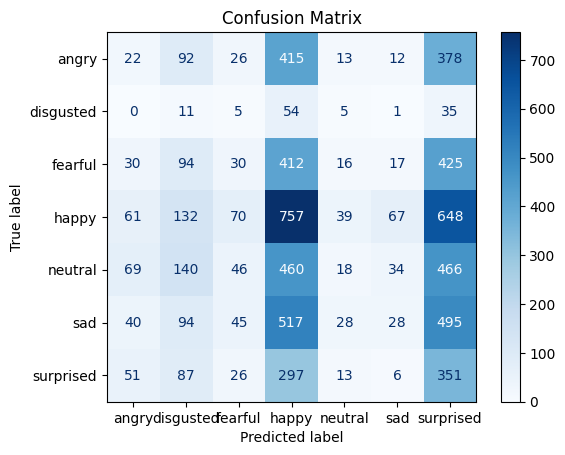

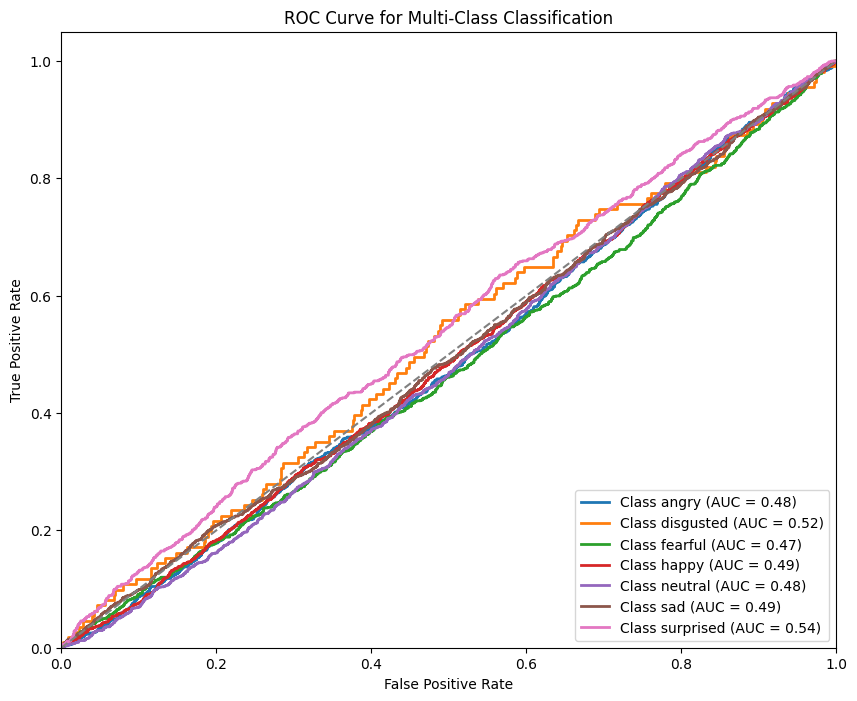

Precision: 0.1599
Recall: 0.1695
F1 Score: 0.1256


In [11]:
#evaluation 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

test_loss, test_accuracy = baseline_model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Make predictions on the validation data
predictions = baseline_model.predict(test_data, steps=None)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys(), zero_division=1))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Calculate and Plot ROC Curve for each class
y_true_bin = label_binarize(true_classes, classes=range(len(test_data.class_indices)))  # Binarize true labels
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
for i, label in enumerate(test_data.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()

# Additional evaluation
precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
